In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as pdr
import warnings

yf.pdr_override() 
plt.style.use("fivethirtyeight")
warnings.filterwarnings("ignore")

yesterday = datetime.now() - timedelta(1)
yesterday = datetime.strftime(yesterday, '%Y-%m-%d')
today = datetime.strftime(datetime.now(), '%Y-%m-%d')

In [2]:
## FUNCTIONS
def getData(ticker="SPY", start="1994-01-01", end=today, interval='1MO'):
    data = yf.download(tickers=ticker, interval=interval, start=start, end=end)
    data.dropna(axis=0, inplace=True)
    return data.reset_index()

def funcMomentum(data, momentum='simple'):
    data['shift1'] = data['Adj Close'].shift(1)
    data['shift3'] = data['Adj Close'].shift(3)
    data['shift6'] = data['Adj Close'].shift(6)
    data.drop(['Open','High','Low', 'Close', 'Volume'], axis=1, inplace=True)
    data.dropna(axis=0, inplace=True)
    composite = (12*(data['Adj Close']/data['shift1']-1)) + (4*(data['Adj Close']/data['shift3']-1)) + (2*(data['Adj Close']/data['shift6']-1))
    simple = ((data['Adj Close']/data['shift6']-1))
    if momentum == 'composite':
        data['momentum'] = composite
    else:
        data['momentum'] = simple
    return data

def acceleratingDualMomentum(interval='1MO', stocks=["spy","scz","tip"], momentum='simple'):
    ## Getting Data
    namespace = globals()
    for i in stocks:
        namespace['%s_data' % str(i)] = getData(ticker=i, end=today, interval=interval)

    ## Creating shift columns and calculating momentum
    for i in stocks:
        namespace['%s_data' % str(i)] = funcMomentum(namespace['%s_data' % str(i)], momentum)
        
    ## series lenght ## hardcoded because ETF release date won't change.
    date = scz_data['Date'] 
    spy_data2 = spy_data.copy()
    spy_data2 = spy_data2.iloc[-len(date):]
    tip_data2 = tip_data.copy()
    tip_data2 = tip_data.iloc[-len(date):]

    
    ## ETF Picking
    etf = []
    ret = []
    for i in range(0, len(date)):
        if ((spy_data2['momentum'].iloc[i] > scz_data['momentum'].iloc[i]) & (spy_data2['momentum'].iloc[i] > 0)):
            etf.append('SPY')
            ret.append((spy_data2['Adj Close'].iloc[i] / spy_data2['shift1'].iloc[i] - 1))
        elif ((scz_data['momentum'].iloc[i] > spy_data2['momentum'].iloc[i]) & (scz_data['momentum'].iloc[i] > 0)):
            etf.append('SCZ')
            ret.append((scz_data['Adj Close'].iloc[i] / scz_data['shift1'].iloc[i] - 1))
        else:
            etf.append('TIP')
            ret.append((tip_data2['Adj Close'].iloc[i] / tip_data2['shift1'].iloc[i] - 1))
   
    ## Returns        
    ret_data = {'date':date, 'etf':etf, 'ret':ret, 'Cumulative Returns':np.cumsum(ret)}
    returns = pd.DataFrame(data=ret_data)
    return returns
#     return tip_data2

In [3]:
monthly = acceleratingDualMomentum(interval='1MO', momentum='simple')
# weekly = acceleratingDualMomentum(interval='1WK', momentum='simple')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# print(len(monthly[monthly['ret']<0]))
# monthly[monthly['ret']<0] 
monthly.tail(15)

,date,etf,ret,Cumulative Returns
164,2021-09-01 00:00:00-04:00,SPY,-0.049650,2.800420
165,2021-10-01 00:00:00-04:00,SPY,0.073592,2.874012
166,2021-11-01 00:00:00-04:00,SPY,-0.008035,2.865977
167,2021-12-01 00:00:00-05:00,SPY,0.042585,2.908562
168,2022-01-01 00:00:00-05:00,SPY,-0.049413,2.859148
169,2022-02-01 00:00:00-05:00,TIP,0.005058,2.864206
170,2022-03-01 00:00:00-05:00,SPY,0.034377,2.898583
171,2022-04-01 00:00:00-04:00,TIP,-0.026343,2.872239
172,2022-05-01 00:00:00-04:00,TIP,-0.011259,2.860980
173,2022-06-01 00:00:00-04:00,TIP,-0.034812,2.826168


In [5]:
for i in [100,1000,10000]:
    print('Investing: ',i ,' would get you: ', i * monthly['Cumulative Returns'].iloc[-1])

Investing:  100  would get you:  279.5105922896994
Investing:  1000  would get you:  2795.105922896994
Investing:  10000  would get you:  27951.059228969938


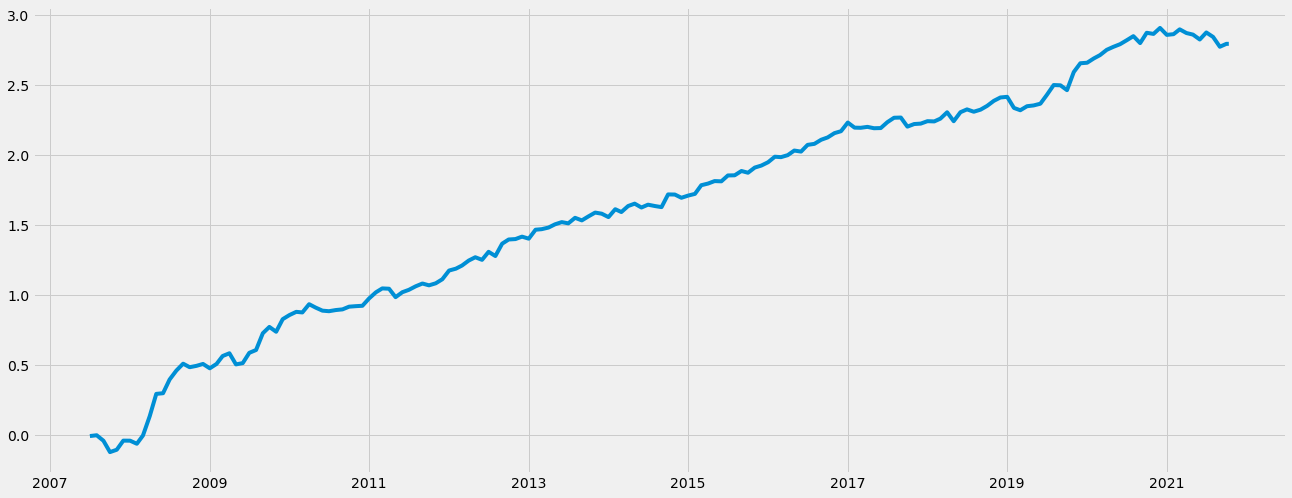

In [6]:
plt.figure(figsize=(20,8))
# plt.plot(weekly['date'], weekly['Cumulative Returns']*100);
# plt.plot(weekly['date'], weekly['ret']);
plt.plot(monthly['date'], monthly['Cumulative Returns']);
# plt.plot(monthly['date'], monthly['ret']);

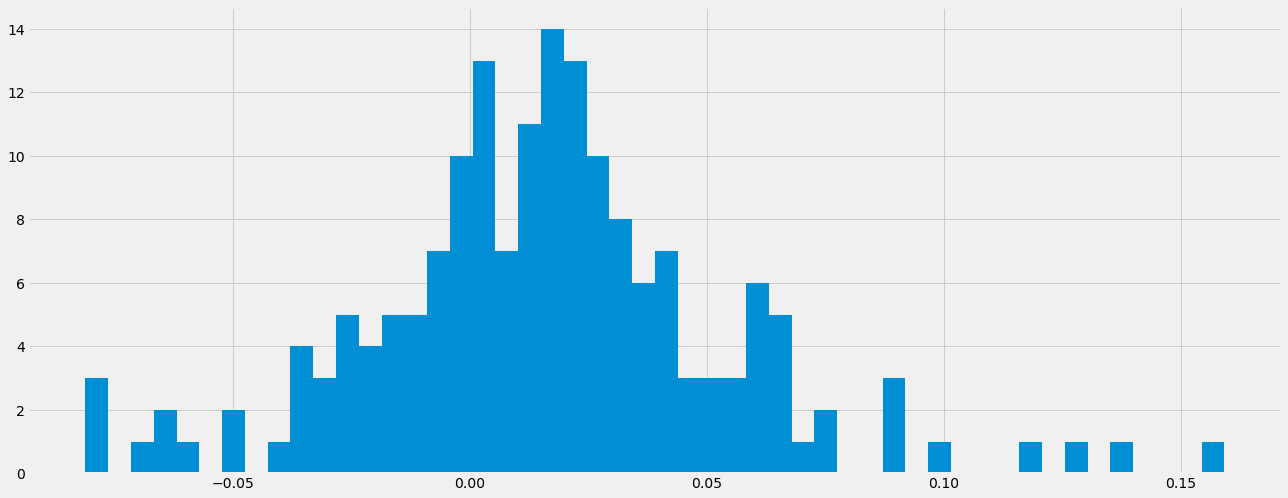

In [7]:
plt.figure(figsize=(20,8))
plt.hist(monthly['ret'], bins=50);

### to-do
- annualized return
- sharpe/sortino ration
- max drawdown
- period drawdown